# Preprocessing data prior to machine learning

For machine learning, we assume that data is in shape `(n_cases, n_channels,
n_timepoints)` for equal length series or a python list with `len` of `[n_cases]` if
the series are unequal length. However, in reality, there are often many steps to get
 your data into this format. We introduce some common uses cases that may be handled
 with preprocessing, and give some suggestions about how to handle them.


In [23]:
import numpy as np

from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from aeon.datasets import load_japanese_vowels, load_plaid
from aeon.registry import all_estimators
from aeon.utils.validation import has_missing, is_equal_length, is_univariate

## Missing values

Missing values are indicated by `NaN` in numpy array. You can test whether any `aeon`
 data structure contains missing values using the utility function



In [26]:
X = np.random.random(size=(10, 2, 200))
has_missing(X)

False

In [27]:
X[5][0][55] = np.NAN
has_missing(X)

True

There are a range of strategies for handling missing values. These include:

1. Use an estimator that internally handles missing values. It is fairly easy for
some algorithms (such as decision trees) to internally deal with missing values,
usually be using it as a distinct series value after discretisation.
2. Removing series with missing: this is often desirable if the train set size is
large, the number of series with missing is small and the proportion of missing
values for these series is high.
3. Interpolating: estimating the missing values from the other series values. This is
 often desirable if the train set size is small and the proportion of missing values
 is low.

Some forecasters can internally handle missing values, but there is very little
support as yet for internally dealing with missing.

In [29]:
all_estimators(
    estimator_types=["classifier", "regressor", "clusterer", "forecaster"],
    filter_tags={"capability:missing_values": True},
    as_dataframe=True,
)

,name,estimator
0,ARIMA,<class 'aeon.forecasting.arima.ARIMA'>
1,AutoARIMA,<class 'aeon.forecasting.arima.AutoARIMA'>
2,AutoETS,<class 'aeon.forecasting.ets.AutoETS'>
3,DirRecTabularRegressionForecaster,<class 'aeon.forecasting.compose._reduce.DirRe...
4,DirRecTimeSeriesRegressionForecaster,<class 'aeon.forecasting.compose._reduce.DirRe...
5,DirectTabularRegressionForecaster,<class 'aeon.forecasting.compose._reduce.Direc...
6,DirectTimeSeriesRegressionForecaster,<class 'aeon.forecasting.compose._reduce.Direc...
7,DummyClassifier,<class 'aeon.classification._dummy.DummyClassi...
8,DummyRegressor,<class 'aeon.regression._dummy.DummyRegressor'>
9,DynamicFactor,<class 'aeon.forecasting.dynamic_factor.Dynami...


Removing series with missing and interpolation is currently best done by you: there
are no transformers to deal with at at the moment. It is on the wish list.

## Unequal length series

Learning from unequal length series is very common. aeon provided two baked in
unequal length collections: the univariate PLAID dataset, and the multivariate
JapaneseVowels dataset:


In [13]:
plaid_X, plaid_y = load_plaid(split="train")
print(
    f"PLAID is univariate = {is_univariate(plaid_X)} has missing ="
    f"{has_missing(plaid_X)} is equal length = {is_equal_length(plaid_X)}"
)
vowels_X, vowels_y = load_japanese_vowels(split="train")
print(
    f"JapaneseVowels is univariate = {is_univariate(vowels_X)} "
    f"has missing = {has_missing(vowels_X)} is "
    f"equal length = {is_equal_length(vowels_X)}"
)

PLAID is univariate = True has missing = False is equal length = False
JapaneseVowels is univariate = False has missing = False is equal length = False


### Handling unequal length

There are two basic strategies for unequal length problems
1. Use an estimator that can internally handle missing values
2. Transform the data to be equal length by, for example, truncating or padding series

At the time of writing, functionality for handling unequal length series is limited.
Estimators with the tag `"capability:unequal_length": True` have the capability to
handle unequal length series. For classification, regression and
clusterign, the
current list is

In [14]:
all_estimators(
    estimator_types=["classifier", "regressor", "clusterer"],
    filter_tags={"capability:unequal_length": True},
    as_dataframe=True,
)

,name,estimator
0,Catch22Classifier,<class 'aeon.classification.feature_based._cat...
1,Catch22Regressor,<class 'aeon.regression.feature_based._catch22...
2,DummyClassifier,<class 'aeon.classification._dummy.DummyClassi...
3,ElasticEnsemble,<class 'aeon.classification.distance_based._el...
4,KNeighborsTimeSeriesClassifier,<class 'aeon.classification.distance_based._ti...
5,KNeighborsTimeSeriesRegressor,<class 'aeon.regression.distance_based._time_s...


You can pass these estimators unequal length series and they will work as expected.

In [15]:
knn = KNeighborsTimeSeriesClassifier()
knn.fit(plaid_X, plaid_y)

KNeighborsTimeSeriesClassifier()

The alternative is to transform your data so that it becomes equal length, and can
then be used with any time series estimator. Two simple examples are tpo pad the
series to the longest series length, or to truncate to the shortest series length. By
 default, padding pads with zeros. Be careful if your data is not normalised, because
  this could then effect the classifier.

In [17]:
from aeon.transformations.collection import PaddingTransformer

pt = PaddingTransformer()
plaid_equal = pt.fit_transform(plaid_X)
plaid_equal.shape

(537, 1, 1344)

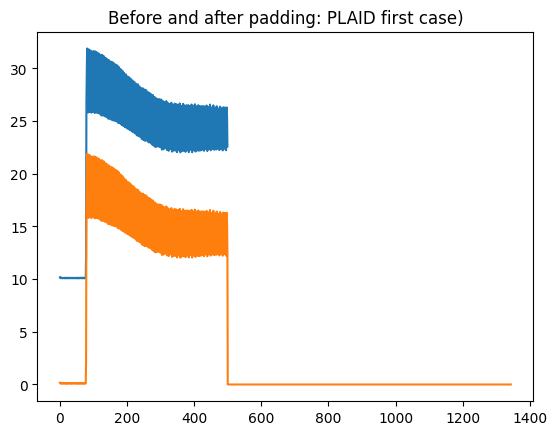

In [21]:
import matplotlib.pyplot as plt

plt.title("Before and after padding: PLAID first case (shifted up for unpadded)")
plt.plot(plaid_X[0][0] + 10)
plt.plot(plaid_equal[0][0])

## Coming soon

Unequally spaced samples
Streaming series: windowing and segmenting
Channel selection for multivariate series
Channel selection for multivariate series